# 신규 아파트 주차 수요 예측

# 모델링

## [미션]

- 모델링을 수행합니다.
    - 전처리를 추가로 진행합니다.
    - 4개 이상의 알고리즘을 사용해 모델링을 수행합니다.
    - 각 모델에 대해 성능 튜닝을 수행합니다.
    - 성능을 비교해 최선의 모델을 선정합니다.
- 데이터 파이프라인 함수를 만듭니다.
- 새로운 데이터를 읽어와 예측을 수행합니다.

## 1. 환경설정

In [ ]:
# 기본 경로
path = ''

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [ ]:
# 구글 드라이브 연결, 패스 지정
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/project/'

### 라이브러리 불러오기

In [945]:
# 기본 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 모델링용 라이브러리 불러오기



# 기타 라이브러리 불러기기
import joblib
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### 데이터 불러오기

- joblib.dump() 함수를 사용해 base_data2.pkl 파일을 읽어옵니다.
- 읽어온 데이터를 data 데이터프레임으로 선언하고 기본 정보를 확인합니다.

In [1200]:
row_data = pd.read_csv('df_ending_2.csv',encoding='utf-8')
row_data.shape

(1140, 30)

### 함수 생성

- 실젯값과 모델이 예측한 값을 시각화해 비교할 함수를 만듭니다.

In [1204]:
# 파이프라인 만들기
def data_pipeline(data):
    apart = data.copy()

    #결측치 처리
    apart['건물형태'].fillna(apart['건물형태'].mode()[0],inplace=True)
    apart['난방방식'].fillna(apart['난방방식'].mode()[0],inplace=True)
    apart['승강기설치여부'].fillna(apart['승강기설치여부'].mode()[0],inplace=True)

    # 변수 추가
    apart['준공연도'] = apart['준공일자'].astype(str).str[:4]
    apart['준공연도'] = apart['준공연도'].astype(int)
    apart['총면적'] = (apart['전용면적'] + apart['공용면적'])*apart['전용면적별세대수']
    

    # 불필요한 변수 제거
    drop_cols = ['단지명','단지내주차면수','준공일자']
    apart.drop(columns=drop_cols,inplace=True)

    # 단지 데이터, 상세 데이터 분리
    data01 = apart.loc[:,['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수','0-9','10월 19일','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-94','95-99','100-']]
    data01.drop_duplicates(inplace=True)
    data01.reset_index(drop=True,inplace=True)

    data02 = apart.loc[:,['단지코드', '총면적', '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료']]
    data02.reset_index(drop=True,inplace=True)


    # 단지 코드별 총면적 합 집계
    df_area = data02.groupby(by='단지코드')[['총면적']].sum()

    # 전용면적 구간별 집계
    bin_list = [0, 42.9, 51.97, 59.9, 68.603, 74.91, 84.083, 84.98, 139.35]
    label_list = ['면적0_42.9', '면적42.9_51.97', '면적51.97_59.9', '면적59.9_68.603', '면적68.603_74.91', '면적74.91_84.083', '면적84.083_84.98', '면적84.98_139.35']
    data02['전용면적구간'] = pd.cut(data02['전용면적'], bins = bin_list, labels = label_list)

    temp = data02.groupby(by=['단지코드','전용면적구간'])[['전용면적별세대수']].sum()
    df_pivot = temp.pivot_table(index='단지코드', columns='전용면적구간', values='전용면적별세대수', aggfunc='sum')
    df_pivot.columns.name=None
    
    # 임대보증금, 임대 평균 집계
    df_rent = data02.groupby(by='단지코드')[['임대보증금','임대료']].mean()
    
    # 집계 결과 병합
    df_area.columns = df_area.columns.str.strip()  # 공백 제거
    df_pivot.columns = df_pivot.columns.str.strip()  # 공백 제거
    base_data = df_area.merge(df_pivot,how='inner',left_index=True,right_index=True)
    base_data = base_data.merge(df_rent,how='inner', left_index=True, right_index=True)
    base_data = base_data.reset_index()

    apart = data01.merge(base_data, how='inner')

    # 난방 방식 : 개별,지역,중앙 세가지로 묶기
    nanbang_dict = {'개별가스난방': '개별', '개별유류난방': '개별', '지역난방': '지역', '지역가스난방': '지역', '지역유류난방': '지역', '중앙가스난방': '중앙', '중앙난방': '중앙', '중앙유류난방': '중앙'}
    apart['난방방식'] = apart['난방방식'].map(nanbang_dict)
    
    # 승강설치여부(0,1)
    elevator_dict = {'전체동 설치': 1, '일부동 설치': 0, '미설치': 0}
    apart['승강기설치여부'] = apart['승강기설치여부'].map(elevator_dict)

    # 단지모드, 지역변수 제거
    drop_cols = ['단지코드','지역']
    apart.drop(columns=drop_cols,inplace=True)

    # 가변수화
    dum_cols = ['건물형태','난방방식']
    apart = pd.get_dummies(apart,drop_first=True,dtype=int)

    # NaN값 채우기
    apart['0-9'].fillna(apart['0-9'].mean(),inplace=True)
    apart['10월 19일'].fillna(apart['10월 19일'].mean(),inplace=True)
    apart['20-29'].fillna(apart['20-29'].mean(),inplace=True)
    apart['30-39'].fillna(apart['30-39'].mean(),inplace=True)
    apart['40-49'].fillna(apart['40-49'].mean(),inplace=True)
    apart['50-59'].fillna(apart['50-59'].mean(),inplace=True)
    apart['60-69'].fillna(apart['60-69'].mean(),inplace=True)
    apart['70-79'].fillna(apart['70-79'].mean(),inplace=True)
    apart['80-89'].fillna(apart['80-89'].mean(),inplace=True)
    apart['90-94'].fillna(apart['90-94'].mean(),inplace=True)
    apart['95-99'].fillna(apart['95-99'].mean(),inplace=True)
    apart['100-'].fillna(apart['100-'].mean(),inplace=True)

    # 극이상치 최대값으로 변경
    rent_extreme_outlier = [642930.0, 586540.0, 950305.0, 573333.3333333334, 634472.5, 600352.0, 620000.0, 815355.7142857143, 744450.0, 767010.0, 759490.0, 699330.0, 600004.0, 600000.0, 580897.5, 622000.0, 715000.0, 803672.5] # 2를 모두 통일된 값으로 바꿈
    rent_min_value = min(rent_extreme_outlier)
    
    new_value = apart['임대료'][apart['임대료'] < min_value].max()
    # 특정 값들을 통일된 값으로 대체
    df_replaced = apart.replace(rent_extreme_outlier, new_value)

    rentaldeposit_extreme_outlier = [101516666.66666667, 189821857.14285713, 76513833.33333333, 114770250.0, 113172333.33333333, 100389000.0, 87417000.0, 89764000.0, 81800000.0, 96250000.0, 170746375.0, 85725000.0, 97085500.0] # 2를 모두 통일된 값으로 바꿈
    rentaldeposit_min_value = min(rentaldeposit_extreme_outlier)
    
    new_value = apart['임대보증금'][apart['임대보증금'] < rentaldeposit_min_value].max()
    # 특정 값들을 통일된 값으로 대체
    df_replaced = df_replaced.replace(rentaldeposit_extreme_outlier, new_value)

    apart = df_replaced.copy()

    return apart

## 2. 모델링

- 모델링을 위한 결측치 처리, 데이터 분할, 스케일링, 가변수화 등을 수행합니다.
- 4개 이상의 알고리즘을 사용하여 모델을 만듭니다.
- 모델 이름은 서로 다르게 합니다. (예: model1, model2...)
- Linear Regression 이외의 알고리즘을 사용한 모델은 GridSearchCV() 함수로 성능 최적화를 수행합니다.
- 적절한 평가지표로 모델의 성능을 평가합니다.
- 실젯값과 예측값을 시각화해 비교합니다.
- 성능 비교를 통해 최선의 모델을 선정합니다.

### (1) 데이터 전처리

- 필요한 전처리를 수행합니다.

In [1206]:
data = data_pipeline(row_data)

In [1208]:
data.head()

,총세대수,준공연도,승강기설치여부,실차량수,0-9,10월 19일,20-29,30-39,40-49,50-59,...,면적68.603_74.91,면적74.91_84.083,면적84.083_84.98,면적84.98_139.35,임대보증금,임대료,건물형태_복도식,건물형태_혼합식,난방방식_중앙,난방방식_지역
0,78,2013,1,109,1288.0,2533.0,2249.0,2125.0,3526.0,3293.0,...,0,0,0,0,56962000.0,950305.000000,0,0,0,0
1,35,2013,1,35,774.0,1273.0,2357.0,2308.0,2842.0,3835.0,...,0,0,0,0,63062000.0,470100.000000,1,0,0,0
2,88,2013,1,88,573.0,470.0,1280.0,2023.0,1517.0,2048.0,...,0,0,0,0,72190000.0,950305.000000,0,0,0,0
3,477,2014,1,943,573.0,470.0,1280.0,2023.0,1517.0,2048.0,...,49,167,111,0,72190000.0,950305.000000,1,0,0,1
4,15,2013,1,21,1414.0,1677.0,4923.0,6481.0,4475.0,4366.0,...,0,0,0,0,55227500.0,340148.333333,1,0,0,0


#### 1) 가변수화

- '건물형태', '난방방식' 변수에 대해 가변수화를 수행합니다.

In [1179]:
# data = data.rename(columns={'0-9': '0-9세','10월 19일': '10-19세','20-29': '20-29세','30-39': '30-39세','40-49': '40-49세','50-59': '50-59세','60-69': '60-69세','70-79': '70-79세','80-89': '80-89세','90-94': '90-94세','95-99': '95-99세','100-': '100세 이상'})

#### 2) x, y 분리

- Target를 지정하고, x와 y로 분리합니다.

In [1211]:
# x, y 분리
target = '실차량수'
x, y = data.drop(columns=target), data[target]

#### 3) 학습용, 평가용 분리

- 학습용, 평가용 데이터를 적절한 비율로 분리합니다.

In [1214]:
# 학습용, 평가용 데이터 분리
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=1)

#### 4) 스케일링

- 필요한 경우 스케일링을 진행합니다.
- 예를 들어 KNN 알고리즘을 사용할 경우입니다.

In [1217]:
# 모듈 불러오기
from sklearn.preprocessing import MinMaxScaler

# 정규화
x_cols = list(x_train)
scaler = MinMaxScaler()
#scaler.fit(x_train)
x_train_s = scaler.fit_transform(x_train)

# 학습 데이터로 학습한 scaler를 그대로 사용 
x_val_s = scaler.transform(x_val)

x_train_s = pd.DataFrame(x_train_s, columns=x_cols)

In [1219]:
# 불러오기
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score, mean_absolute_error

### (1) 모델 1: KNN

In [1221]:
# 파라미터 선언
param = {'n_neighbors': range(1, 16)}

model1 = GridSearchCV(KNeighborsRegressor(),
                    param,
                    cv=5,
                    scoring='r2'
                    )
model1.fit(x_train_s,y_train)

# 변수 중요도 시각화
print(model1.best_score_)
print(model1.best_params_)
result['KNN'] = model1.best_score_

0.5395875039085762
{'n_neighbors': 4}


### (2) 모델 2: LinearRegression

In [1225]:
# 모델링
model2 = LinearRegression()

# 학습하기
model2.fit(x_train, y_train)

# 예측하기
y_val_pred = model2.predict(x_val)

# 평가하기
print('MAE:', mean_absolute_error(y_val, y_val_pred))
print('R2:', r2_score(y_val, y_val_pred))

result['LinearRegression'] = r2_score(y_val, y_val_pred)

MAE: 143.56344400580235
R2: 0.7478956644709269


### (3) 모델 3: DecisionTree

In [981]:
# 파라미터 선언
param = {'max_depth': range(1, 21),
        'max_leaf_nodes':range(1,11),
        'min_samples_split':range(1,11)}

model3 = GridSearchCV(DecisionTreeRegressor(random_state=1),
                    param,
                    cv=5,
                    scoring='r2'
                    )
model3.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1),
             param_grid={'max_depth': range(1, 21)}, scoring='r2')

In [982]:
# 변수 중요도 시각화
print(model3.best_score_)
print(model3.best_params_)
result['DecisionTreeRegressor'] = model3.best_score_

0.5375843822809776
{'max_depth': 4}


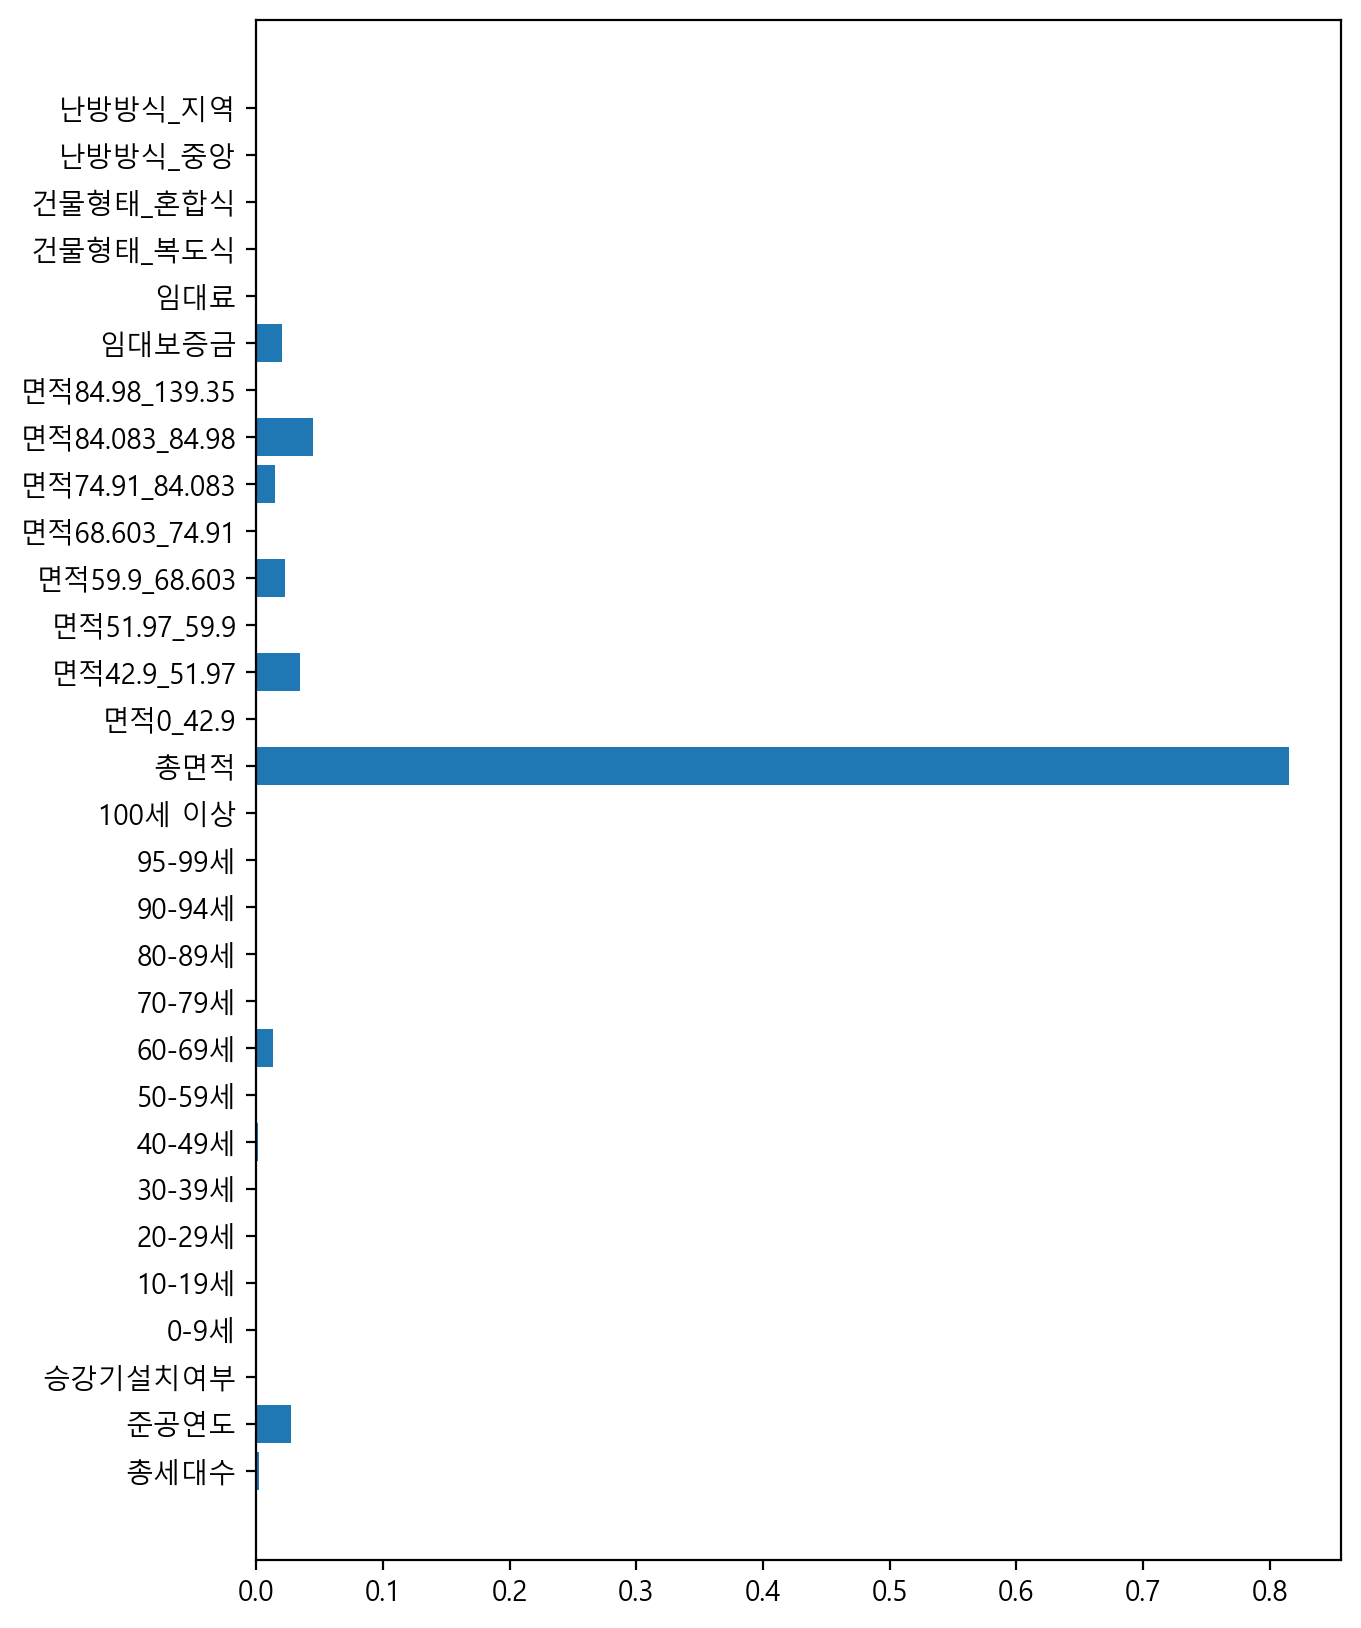

In [988]:
plt.figure(figsize=(7,10))
plt.barh(list(x),model3.best_estimator_.feature_importances_)
plt.show()

### (4) 모델 4: RandomForest

In [1234]:
# 파라미터 선언
param = {'max_depth': range(1, 21)}

model4 = GridSearchCV(RandomForestRegressor(random_state=1),
                    param,
                    cv=5,
                    scoring='r2'
                    )
model4.fit(x_train,y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_depth': range(1, 21),
                         'max_leaf_nodes': range(1, 3),
                         'min_samples_split': range(1, 3)},
             scoring='r2')

In [1263]:
# 변수 중요도 시각화
print(model4.best_params_)
print(model4.best_score_)
result['RandomForestRegressor'] = model4.best_score_

{'max_depth': 1, 'max_leaf_nodes': 2, 'min_samples_split': 2}
0.5001297949062844


<BarContainer object of 30 artists>

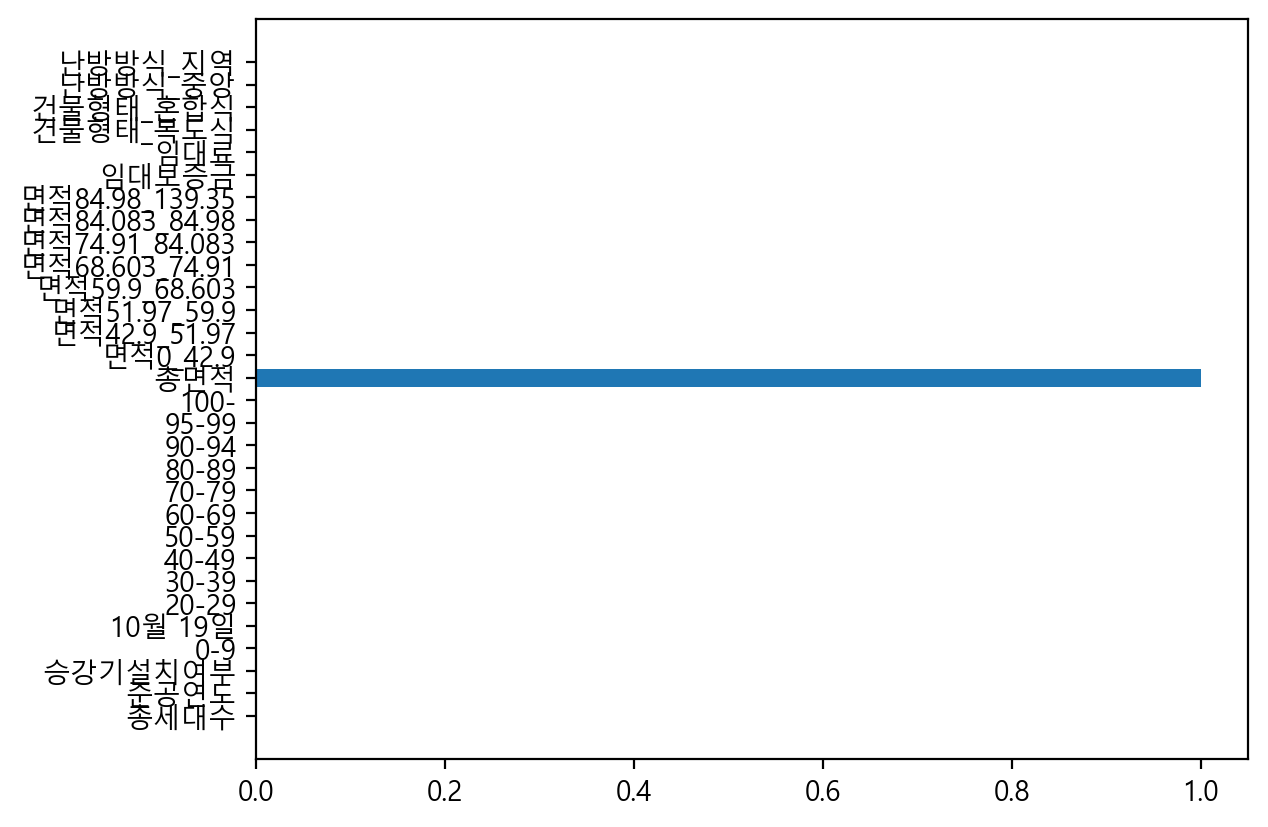

In [1265]:
plt.barh(list(x),model4.best_estimator_.feature_importances_)

### (5) 모델 5: LGB

In [1268]:
# 파라미터 선언
param = {'max_depth': range(1, 21),
        'n_estimators': range(100,201,10),
        'num_leaves':range(31,51)}

model5 = GridSearchCV(LGBMRegressor(verbose=-1,random_state=1),
                    param,
                    cv=5,
                    scoring='r2'
                    )
model5.fit(x_train,y_train)


KeyboardInterrupt: 

In [1004]:
# 변수 중요도 시각화
print(model5.best_params_)
print(model5.best_score_)
result['LGBMRegressor'] = model5.best_score_

{'max_depth': 2}
0.6914995231135527


<BarContainer object of 30 artists>

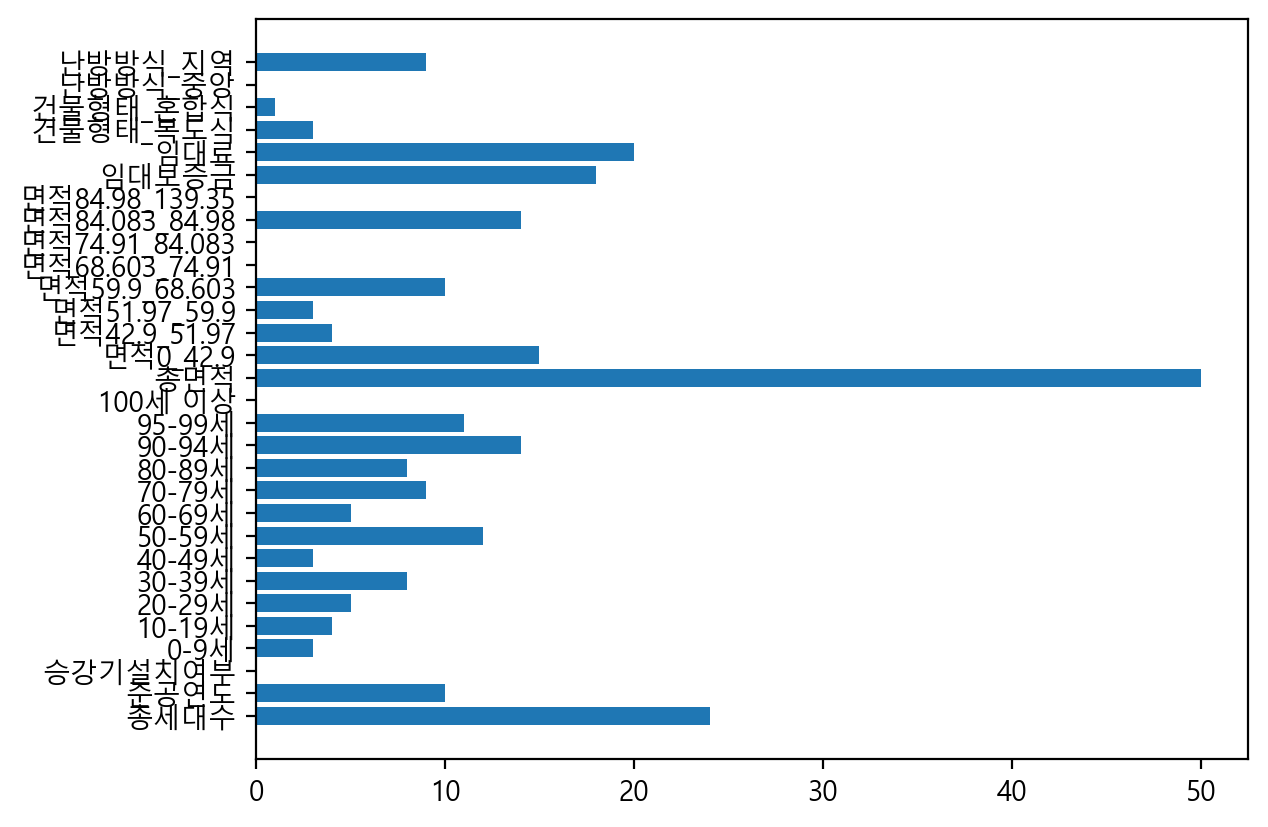

In [1006]:
plt.barh(list(x),model5.best_estimator_.feature_importances_)

### (6) 모델 6: XGBoost

In [1008]:
# 파라미터 선언
param = {'max_depth': range(1, 16)}

model6 = GridSearchCV(XGBRegressor(),
                    param,
                    cv=5,
                    scoring='r2'
                    )
model6.fit(x_train,y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': range(1, 16)}, scoring='r2')

In [1009]:
# 변수 중요도 시각화
print(model6.best_params_)
print(model6.best_score_)
result['XGBoost'] = model6.best_score_

{'max_depth': 3}
0.6871398524040468


<BarContainer object of 30 artists>

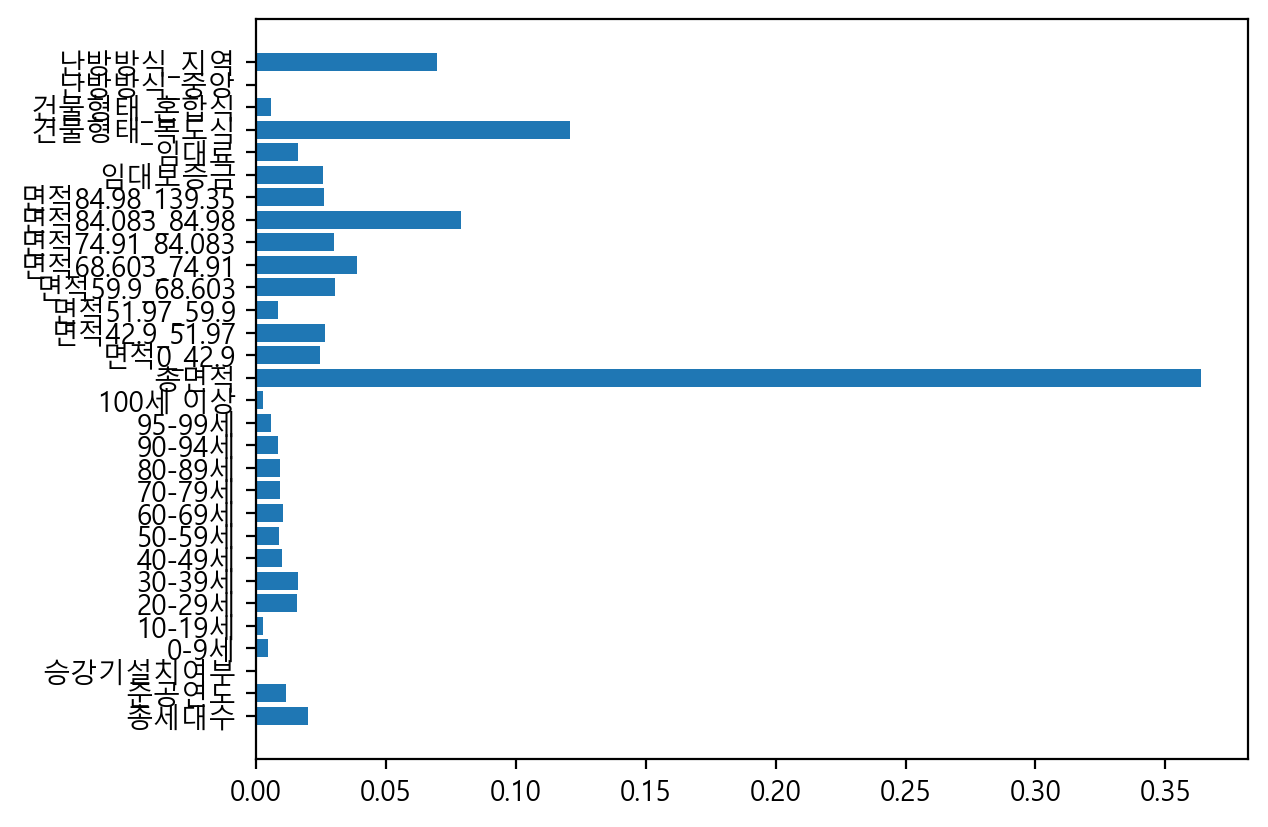

In [1010]:
plt.barh(list(x),model6.best_estimator_.feature_importances_)

### (7) 성능 비교

- 각 모델의 성능을 비교합니다.

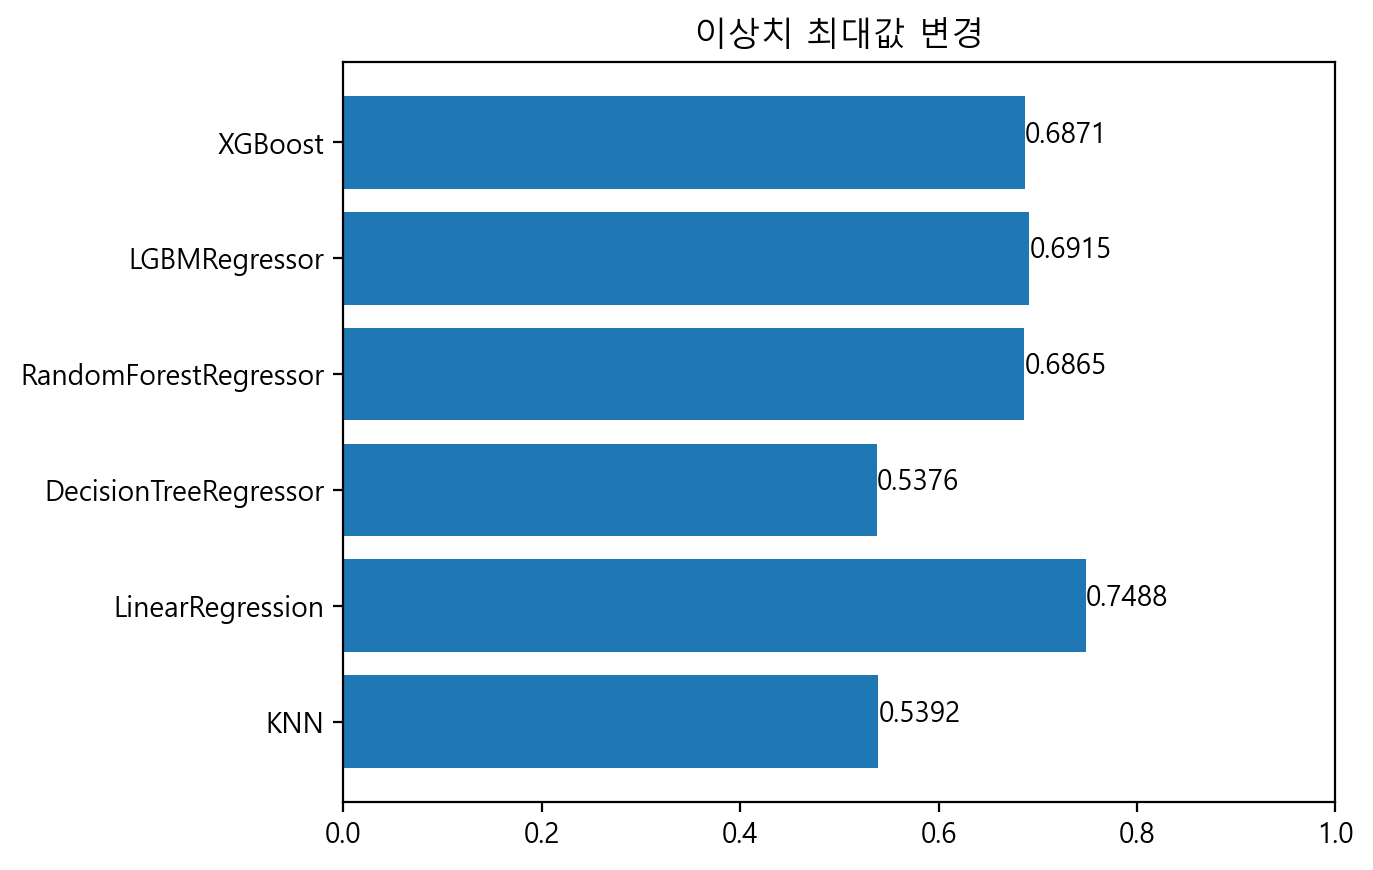

In [1012]:
plt.barh(list(result),result.values())

for index, value in enumerate(result.values()):
    plt.text(value, index, str(value.round(4)))
plt.xlim(0, 1)
plt.title('이상치 최대값 변경')
plt.show()
